# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[int(num_test/2):], newsgroups_test.target[int(num_test/2):]
dev_data, dev_labels = newsgroups_test.data[:int(num_test/2)], newsgroups_test.target[:int(num_test/2)]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('test label shape:', test_labels.shape)
print('dev label shape:', dev_labels.shape)

print('labels names:', newsgroups_train.target_names)

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


**(1)**  
For each of the first 5 training examples, print the text of the message along with the label.

[2 pts]

In [3]:
def P1(num_examples=5):
### STUDENT START ###
    for msg in range(0, num_examples):
        label = train_labels[msg]
        label_text = newsgroups_train.target_names[label]
        print(f"\n\u001b[1m**\n Message Number {msg+1} which has label {label}: {label_text}\n**\u001b[0m\n")
        print(train_data[msg])

### STUDENT END ###
P1(5)


**
 Message Number 1 which has label 1: comp.graphics
**

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych

**
 Message Number 2 which has label 3: talk.religion.misc
**



Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Kores

**(2)**  
Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

**a.** The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

**b.** What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

**c.** Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

**d.** Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

**e.** Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

**f.** Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

[6 pts]

In [4]:
def P2():
### STUDENT START ###
    '''This function answers problem 2, doing some basic manipulation and EDA on the messages using CountVectorizer.
    Each message is an "example", or "row" in the vectorized sparse matrix. 
    Each word is a "feature" or "column" in the vectorized sparse matrix.
    Entries in the array represent the frequency for a given word in the given example.
    '''
    # (a)
    # Instantiate, fit and transform the messages to vectors, creating the vocabulary (feature list) along the way
    vectorizer = CountVectorizer()
    vectors = vectorizer.fit_transform(train_data)
    vocab = vectorizer.vocabulary_  # Obtain the vocabulary
    
    # num_features is the number of unique words >= 2 letters (could also be done with .get_feature_names)
    num_features = len(vocab)
    print("\u001b[1m(a)\u001b[0m\nSize of Vocabulary = ",num_features)
    
    # sum across rows and take the average to find average number of words in each message
    avg_per_example = np.mean(vectors.getnnz(1))
    print(f"Average Non-zero features (i.e. unique words) per example: {avg_per_example:.5}")
    
    # Calculate matrix size, and use the number of non-zero entries in the sparse matrix to find the fraction of non zero entries.
    total_entries = vectors.get_shape()[0]*vectors.get_shape()[1]
    density1 = vectors.nnz/total_entries
    print(f"Fraction Non Zero entries in Training Matrix (density) = {density1:.4} - a very sparse matrix")
    
    # (b)
    # Select first and last feature names and print alphabetically
    first_last = [vectorizer.get_feature_names()[0],vectorizer.get_feature_names()[-1]]
    print("\n\u001b[1m(b)\u001b[0m\nFirst (0th) and Last Feature strings, sorted alphabetically: ",sorted(first_last))
    
    # (c)
    # fit and transform the data using a specified vocabulary of only 4 words - in order to count the occurence of those words
    vectorizer2 = CountVectorizer(vocabulary= ["atheism", "graphics", "space", "religion"]) # specify the vocabulary to be used
    vectors2=vectorizer2.fit_transform(train_data)
    
    # print the shapes from the original fit_transform and current to ensure we got it right
    print("\n\u001b[1m(c)\u001b[0m\nOriginal vector matrix shape:", vectors.get_shape())
    print('Specified Vocabulary ["atheism", "graphics", "space", "religion"] vector matrix shape:', vectors2.get_shape())
    print(f"New Training Vectors Shape Confirmed correct, "
          f"with {vectors2.get_shape()[1]} features and {vectors2.get_shape()[0]} examples")
    
    # Calculate the average non-zero words per example (same process as in (a))
    avg_per_example2 = np.mean(vectors2.getnnz(1))
    print(f"Average Non-zero features per example with new 4 word vocabulary: {avg_per_example2:.5}")
    print("This means that on average, every message has approximately one of the 4 word vocabulary words")
    total_entries2 = vectors2.get_shape()[0]*vectors2.get_shape()[1]
    density2 = vectors2.nnz / total_entries2
    print(f"Vectorized fraction non zero with new Vocabulary = {density2:.4} - "
          f"a factor of {(density2/density1):.3} more dense than previous")
    
    # (d)
    # Re-specify the vectorizer to include only 2 and 3 letter combinations, then determine new vocabulary size
    vectorizer3 = CountVectorizer(ngram_range=(2,3),analyzer='char')
    vectors3 = vectorizer3.fit_transform(train_data)
    vocab3 = vectorizer3.vocabulary_
    print(f"\n\u001b[1m(d)\u001b[0m\nConsidering only 2 and 3 character n-grams, the vocabulary size is now {len(vocab3)} n-grams.")
    print(f"New Vocabulary is {len(vocab3)/len(vocab):.3} times larger than original.")
    print(f"Average Non-zero features per example for bi- and tri- character grams is {(np.mean(vectors3.getnnz(1))):.5}")
    
    # (e)
    # Specify vectorizer such that words must occur in at least 10 documents (minimum document frequency=10)
    # Compare size of resulting vocabulary
    vectorizer4 = CountVectorizer(min_df=10)
    vectors4 = vectorizer4.fit_transform(train_data)
    vocab4 = vectorizer4.vocabulary_
    print(f"\n\u001b[1m(e)\u001b[0m\nConsidering only words that occur in at least 10 documents,"
          f" the vocabulary size becomes {len(vocab4)} words.")
    print(f"New Vocabulary is {len(vocab4)/len(vocab):.3} fraction of original vocabulary size.")
    print(f"Average Non-zero features per example when words must appear in "
          f"at least 10 documents is {(np.mean(vectors4.getnnz(1))):.5}")
    
    # (f)
    # Determine what fraction of words in Dev Data are not in Train Data by looking at feature_name sizes
    vectorizer_dev = CountVectorizer() # Using defaults for CountVectorizer
    vectors_dev = vectorizer_dev.fit_transform(dev_data) # Fit and transform
    
    # Define the lists for each group of feature names for simplicity
    dev_feats = vectorizer_dev.get_feature_names() 
    train_feats = vectorizer.get_feature_names()
    
    # Change feature name lists to sets to enable subtraction, which identifies words in dev that are not in train
    words_in_dev_only = set(dev_feats)-set(train_feats)

    # Print Results, calculating fraction of dev words not in the training vocabulary
    print(f"\n\u001b[1m(f)\u001b[0m\nUsing the Standard CountVectorizer, \nTraining vocabulary has {len(train_feats)} words")
    print(f"Dev vocabulary has {len(dev_feats)} words")
    print(f"{len(words_in_dev_only)} words are in dev that are not in training")
    print(f"Words in dev that are not in train as fraction of dev data vocabulary size: "
          f" {(len(words_in_dev_only)/len(dev_feats)):.3}\n"
          f"This is a quarter of the words in the dev set, which may result in an increased amount of misidentifications later")
    
    
### STUDENT END ###
P2()

(a)
Size of Vocabulary =  26879
Average Non-zero features (i.e. unique words) per example: 96.706
Fraction Non Zero entries in Training Matrix (density) = 0.003598 - a very sparse matrix

(b)
First (0th) and Last Feature strings, sorted alphabetically:  ['00', 'zyxel']

(c)
Original vector matrix shape: (2034, 26879)
Specified Vocabulary ["atheism", "graphics", "space", "religion"] vector matrix shape: (2034, 4)
New Training Vectors Shape Confirmed correct, with 4 features and 2034 examples
Average Non-zero features per example with new 4 word vocabulary: 0.26844
This means that on average, every message has approximately one of the 4 word vocabulary words
Vectorized fraction non zero with new Vocabulary = 0.06711 - a factor of 18.7 more dense than previous

(d)
Considering only 2 and 3 character n-grams, the vocabulary size is now 35478 n-grams.
New Vocabulary is 1.32 times larger than original.
Average Non-zero features per example for bi- and tri- character grams is 684.19

(e)
Cons

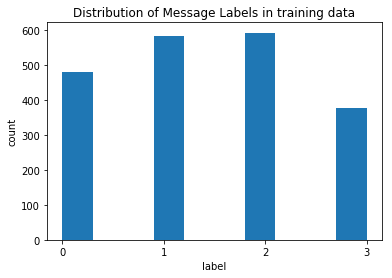

In [5]:
# Histogram to understand distribution of message labels in training data
plt.hist(train_labels)
plt.xticks(np.arange(4),['0','1','2','3'])
plt.xlabel('label')
plt.ylabel('count')
plt.title('Distribution of Message Labels in training data')
plt.show()

-----

**(3)**  
Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

**a.** Why doesn't nearest neighbors work well for this problem?

**b.** Any ideas why logistic regression doesn't work as well as Naive Bayes?

**c.** Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

[4 pts]

kNN model, Euclidean Distance, Grid Search optimization for k (no. of nearest neighbours)


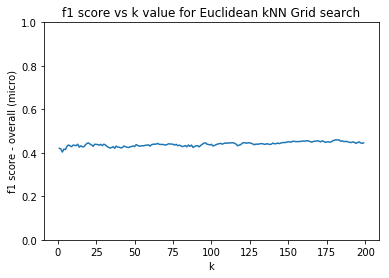

Best k value = 181 with f1 = 0.4602 on Train Data with GridSearch
f1 Score on Dev Data using best k = 0.4379

Multinomial naive Bayes, Grid Search optimization for alpha (Laplace Smoothing)


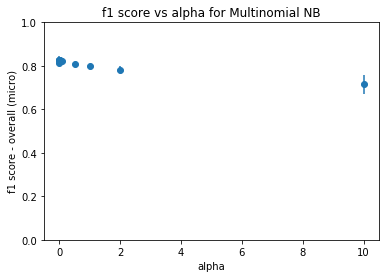

Best Alpha value = 0.01 with f1 = 0.8284 on Train Data with GridSearch
f1 Score on Dev Data using best Alpha = 0.7796

Logistic Regression, Optimization for C (L2 Regularization Strength)

Inverse Regularization Strength C and squared sum of weights(coefficients) for each class

C	Class 0	Class 1	Class 2	Class 3
0.0001	0.007702	0.01194	0.009435	0.009103
0.001	0.1651	0.201	0.1807	0.1872
0.01	2.541	2.94	2.862	2.25
0.1	27.14	24.66	27.46	23.02
0.2	49.75	42.74	49.33	42.67
0.3	69.24	57.86	67.9	59.76
0.4	86.73	71.15	84.2	75.05
0.5	102.6	83.09	99.03	89.0
0.75	137.3	109.0	130.9	119.6
1.0	167.0	130.9	158.0	145.7
1.5	216.6	167.5	202.8	189.7


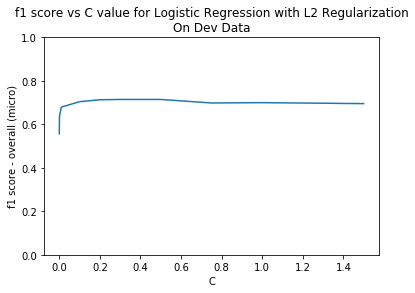

Best C value = 0.3 with f1 = 0.7145 on Dev Data


In [6]:
### STUDENT START ###

def kopt2(kupper, train_data, train_labels, dev_data, dev_labels):
    '''Train and predict using a kNN model (Euclidean distance) on k values from 1 to kupper on train data
    Using GridSearch to find k vs f1 score
    Report f1 score using optimum k on Dev Data
    '''
    # Define Classifier
    knn_clf = KNeighborsClassifier()
    
    # Define ks and Grid search, use f1 micro for scoring
    krange = np.arange(1,kupper)
    kvals = {'n_neighbors':krange}
    clf = GridSearchCV(knn_clf,kvals,scoring='f1_micro',cv=5,iid=False)
    results = clf.fit(train_data,train_labels).cv_results_
    ks = results['param_n_neighbors']
    means = results['mean_test_score']
    ranks = results['rank_test_score']
    
    # Print graph
    plt.plot(ks,means)
    plt.ylim(0,1)
    plt.xlabel("k")
    plt.ylabel("f1 score - overall (micro)")
    plt.title("f1 score vs k value for Euclidean kNN Grid search")
    plt.show()
    
    # Find index of best f1 score and print results from Grid search
    best_idx = np.where(ranks==1)[0][0] # Best k value
    print(f"Best k value = {ks[best_idx]} with f1 = {means[best_idx]:.4} on Train Data with GridSearch")
   
    # Predict on Dev Data and score (checked this correctly uses f1 micro and best k 
    # by running a classification report separately, not shown here)
    pred_score = clf.score(dev_data,dev_labels)
    print(f"f1 Score on Dev Data using best k = {pred_score:.4}")
       
    return

def mnb(train_data,train_labels,dev_data,dev_labels):
    '''Train and predict using a multinomial naive bayes model and GridSearch 
    to find alpha (Laplace smoothing parameter) vs f1 score
    Report f1 score using optimum alpha on Dev Data
    '''
    # Define classifier
    mnb_clf = MultinomialNB()
    
    # Define alphas and GridSearch, using f1 micro for scoring
    alphas = {'alpha': [1.0e-10, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
    clf = GridSearchCV(mnb_clf,alphas,scoring='f1_micro',cv=5,iid=False)
    results = clf.fit(train_data,train_labels).cv_results_
    alfs = results['param_alpha']
    means = results['mean_test_score']
    stdevs = results['std_test_score']
    ranks = results['rank_test_score']
    
    # Print graph
    plt.errorbar(alfs,means,yerr=stdevs,fmt='o')
    plt.ylim(0,1)
    plt.xlabel('alpha')
    plt.ylabel('f1 score - overall (micro)')
    plt.title('f1 score vs alpha for Multinomial NB')
    plt.show()
    
    # Find index of best f1 score and print results from Grid Search
    best_idx = np.where(ranks==1)[0][0] # Best k value
    print(f"Best Alpha value = {alfs[best_idx]} with f1 = {means[best_idx]:.4} on Train Data with GridSearch")
    
    # Predict on Dev Data and score
    pred_score = clf.score(dev_data,dev_labels)
    print(f"f1 Score on Dev Data using best Alpha = {pred_score:.4}")
    
    return


def logreg(train_data,train_labels,dev_data,dev_labels):
    '''Train and predict using a Logistic Regression model to find
    C (L2 Regularization Strength) vs f1 score on Train Data
    Report f1 score using optimum C on Dev Data
    Also output the sum of the squared weight values for each class for each setting of the C parameter.
    '''
            
    # Define C values. We are not using GridSearch here, in order to output the sum of the squared 
    # weights for each class for each value of the C parameter
    cs = [0.0001,0.001, 0.01, 0.1, 0.2,0.3,0.4,0.5,0.75, 1.0, 1.5]
    f1scores = []
    print(f"Inverse Regularization Strength C and squared sum of weights(coefficients) for each class\n"
          f"\nC\tClass 0\tClass 1\tClass 2\tClass 3") # table header
    
    for c in cs:
        # Run classifier for each value of C (inverse regularization strength). Use ovr - one vs. rest, not multinomial
        logreg_clf = LogisticRegression(multi_class='ovr', penalty='l2', solver='liblinear',C=c)
        model = logreg_clf.fit(train_data,train_labels) # Train
        pred_labels = model.predict(dev_data) # Predict
        f1score = metrics.f1_score(dev_labels,pred_labels,average='micro') # Score Predictions for given C using f1 micro
        f1scores.append(f1score)
        sums=np.sum(np.square(model.coef_),axis=1) # Get sums of squared model coefficients (weights)
        print(f"{c}\t{sums[0]:.4}\t{sums[1]:.4}\t{sums[2]:.4}\t{sums[3]:.4}") # Print table
              
    # Print graph
    plt.plot(cs,f1scores)
    plt.ylim(0,1)
    plt.xlabel("C")
    plt.ylabel("f1 score - overall (micro)")
    plt.title("f1 score vs C value for Logistic Regression with L2 Regularization\nOn Dev Data")
    plt.show()
    
    # Find index for best f1score on Dev Data and print
    best_idx = f1scores.index(max(f1scores))
    print(f"Best C value = {cs[best_idx]} with f1 = {f1scores[best_idx]:.4} on Dev Data")
        
    return


def P3():
    '''Comparison of classification models for identification of group that messages belong to
    1) Create new_train_data using CountVectorizer defaults on the train_data set
    2) Fit a kNN model, and optimize for k, reporting f1 score
    3) Fit a Multinomial NB model and optimize for alpha
    4) Fit a logistic regression model and find optimum regularization strength C using I2 regularization
    '''
    
    # Vectorize train and dev messages. - USE transform from TRAIN on DEV data to ensure using same vocabulary (# of features)
    vectorizer = CountVectorizer()
    new_train_data = vectorizer.fit_transform(train_data)
    new_dev_data = vectorizer.transform(dev_data)
    
    # kNN Model
    # Note that in testing, I ran this up to k=1000 and determined that for k>200, the f1 continues to drop
    # So, I set maximum k for this assignment at 200 to minimize run time
    print("\u001b[1mkNN model, Euclidean Distance, Grid Search optimization for k (no. of nearest neighbours)\u001b[0m")
    kupper=200 # Best k is 181, f1=0.4602 
    kopt2(kupper,new_train_data,train_labels,new_dev_data,dev_labels)
        
    # Multinomial Naive Bayes Model
    print(f"\n\u001b[1mMultinomial naive Bayes, Grid Search optimization for alpha (Laplace Smoothing)\u001b[0m")
    mnb(new_train_data,train_labels,new_dev_data,dev_labels)
    
    # Logistic Regression Model
    print(f"\n\u001b[1mLogistic Regression, Optimization for C (L2 Regularization Strength)\u001b[0m\n")
    logreg(new_train_data,train_labels,new_dev_data,dev_labels)
        
### STUDENT END ###
P3()

**ANSWER:**  
**a.** Why doesn't nearest neighbors work well for this problem?  

  In this case, the training matrix (dataset) is very very sparse. Because it is sparse, the closest neighbours are still too far away to give a good estimate - i.e. this is the curse of dimensionality - we have a dimension of 26879 features, but only 2034 training examples. If we could narrow down to just the 'important' features, and bring the dimension of the feature space to say 300 or so, then kNN might work better.
  
**b.** Any ideas why logistic regression doesn't work as well as Naive Bayes?  

In this case, likely logistic regression is not working as well as Naive Bayes (0.78 vs. 0.83 on the f1 score) because the data set size is so small (2034), thus logistic regression cannot obtain higher fidelity. Additionally, logistic regression in this case may be suffering from overfitting due to the large number of features and (relatively) small number of examples.  

**c.** Logistic regression estimates a weight vector for each class, which you can access with the coef_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.  

For logistic regression in SciKit learn, the value of C is the inverse regularization strength. The cost function/objective in SciKit Learn (using notation from class, noting $y \in \{-1,1\}$) is approximately:  

$argmin_{\theta}[C \sum_{i=1}^n log(\exp(- y_iX_i^T \theta) + 1)+\frac{1}{2}\theta^T \theta]$  

from which we can see that as C gets smaller, the amount of regularization gets larger. In other words, as C gets bigger, the effect of the sum of the sqaured weights - the regularization term gets bigger. Regularization is meant to reduce the effect of extraneous terms and thus reduce overfitting - either by reducing the number of terms or, as we do here, by reducing the size of the coefficients (weights). So, as we reduce C, we see the sum of the weights gets smaller, indicating less effect and thus less overfitting. We have to make sure not to reduce C so far that we get under fitting, however, which we can see starts to happen for very small values of C in the plot.

---

**(4)**  
Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

[5 pts]

In [7]:
def P4():
### STUDENT START ###
    """Train Logistic Regression Model using best C value from Part 3 on Train Data
    Print the 5 features with the largest weights for each label and print.
    Do the same for the bigram (word) features and compare."""
    
    # Vectorize the data using unigrams
    vectorizer = CountVectorizer()
    new_train_data = vectorizer.fit_transform(train_data)
    
    # Define the classifier
    clf = LogisticRegression(multi_class='ovr', penalty='l2', solver='liblinear',C=0.3)
    
    # Train the model using L2 regularization
    model = clf.fit(new_train_data,train_labels) # Train
    
    # Each row is a class, each column is a feature
    weights = model.coef_
    features = np.array(vectorizer.get_feature_names())
    
    # -i.e. elements of weights at indices 0,1,2,3,4 in largest are largest. 
    ind_largest = np.argpartition(-weights,4)  # reverse partition at element index 4 (5th element)
    ind_largest=ind_largest[:,0:5]
        
    wts_arr = np.zeros((20,4))
    
    print("\u001b[1mTop 5 features per class and corresponding weights for unigrams\u001b[0m")
    print(f"Number of features in unigram: {features.shape[0]}")
    print(f"Feature\t\t\tClass 0\t\tClass 1\t\tClass 2\t\tClass 3")
    
    # Reshaping and concatenating weights and features arrays to allow proper printing
    for row in range(0,weights.shape[0]):
        wts_arr[:,row]=weights[row][ind_largest].reshape(20,)
        
    top_feats_arr = features[ind_largest].reshape(20,1) 
    answer = np.concatenate((top_feats_arr,wts_arr),axis=1)
    
    for row in range(0,answer.shape[0]):
        print(f"{answer[row,0]:20}\t{answer[row,1]:8.8}\t{answer[row,2]:8.8}\t{answer[row,3]:8.8}\t{answer[row,4]:8.8}")

        
    # Now use bigram word features instead
    vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(2,2))
    new_train_data2 = vectorizer2.fit_transform(train_data)

    model2 = clf.fit(new_train_data2,train_labels) # Train
    weights2 = model2.coef_

    features2 = np.array(vectorizer2.get_feature_names()) 
    ind_largest2 = np.argpartition(-weights2,4)  # reverse partition at element index 4 
    ind_largest2=ind_largest2[:,0:5]
    
    wts_arr2 = np.zeros((20,4))
    
    print("\n\u001b[1mTop 5 features per class and corresponding weights for bigrams\u001b[0m")
    print(f"Number of features in bigram by word: {features2.shape[0]}")
    print(f"Feature\t\t\tClass 0\t\tClass 1\t\tClass 2\t\tClass 3")
    
    for row in range(0,weights2.shape[0]):
        wts_arr2[:,row]=weights2[row][ind_largest2].reshape(20,)
    
    top_feats_arr2 = features2[ind_largest2].reshape(20,1) 
    answer2 = np.concatenate((top_feats_arr2,wts_arr2),axis=1)
    
    for row in range(0,answer2.shape[0]):
        print(f"{answer2[row,0]:20}\t{answer2[row,1]:8.8}\t{answer2[row,2]:8.8}\t{answer2[row,3]:8.8}\t{answer2[row,4]:8.8}")  
        
    print(f"\nFor Reference, classes 0-3:{newsgroups_train.target_names}")
        
### STUDENT END ###
P4()

Top 5 features per class and corresponding weights for unigrams
Number of features in unigram: 26879
Feature			Class 0		Class 1		Class 2		Class 3
bobby               	0.707706	-0.16893	-0.24676	-0.33375
atheists            	0.700147	-0.09024	-0.23044	-0.50964
religion            	0.693179	-0.43509	-0.56781	-0.03431
atheism             	0.691936	-0.30468	-0.30962	-0.33979
islam               	0.591712	-0.09823	-0.24399	-0.24685
graphics            	-0.56206	1.413049	-0.94511	-0.53644
image               	-0.39450	0.955437	-0.56576	-0.32264
file                	-0.23893	0.915709	-0.59518	-0.42843
3d                  	-0.26338	0.810864	-0.48120	-0.27277
computer            	0.024697	0.751130	-0.48876	-0.33673
space               	-0.92295	-0.97772	1.659410	-0.83871
orbit               	-0.30567	-0.48220	0.868866	-0.40993
nasa                	-0.39544	-0.36039	0.743749	-0.35326
launch              	-0.31638	-0.34694	0.679010	-0.24335
spacecraft          	-0.25569	-0.27397	0.613890	-0.23534

**ANSWER:**  

The top 5 unigrams seem very specific to the particular subject matter. However, the top 5 bigram features are much less identifiable - in fact 'cheers kent' appears in the top 5 for 2 different classes. This means that in order to properly classify the messages, unigrams are much more specific in this case. If we used only bigrams to classify the messages we would likely end up with much poorer performance.  

Also to note, the weights for the bigrams are in general smaller than the unigrams, indicating that the individual features have less importance in the bigram case, leading again to poorer performance in identifying a class for a new input - i.e. less able to generalize.  

Finally, we note that the only positive weights for each class are the top 5 features, while the weights for the top 5 features of the other classes are then negative. This indicates the 'promotion' of the appropriate feature and 'demotion' of the less useful features for identifying each class.

----

**(5)**  

Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

[4 pts]

In [8]:
def empty_preprocessor(s):
    return s

def better_preprocessor(s):
    ### STUDENT START ###
    '''add stuff'''
    
    # Making a copy of the input string
    new_s = s
    
    # Lowercase all
    new_s = s.lower()
    
    # remove all non alpha numerics, replace with spaces
    new_s = re.sub(r'[^A-Za-z0-9]+',' ',new_s)
    
    # tokenize numbers or words with digits in them, replacing with word 'number'
    new_s = re.sub(r'\d+',r'number',new_s)
    new_s = re.sub(r'number(\w*)',r'number',new_s)
    
    #eliminate longer words (more than 11 letters)
    new_s = re.sub(r'[a-z]{12,}',r' ',new_s)
    
    #remove endings - by trial and error
    new_s = re.sub(r'(ly|less|ful|ive|ish|ize|tion|ment|ity|ent)*?','',new_s)
    
    return new_s

def fp(train_data,train_labels,dev_data,dev_labels):
    '''Function to fit the logistic regression, predict and return the f1 micro score'''
    # Train the logistic regression model using L2 regularization and optimum C from Part 3
    clf = LogisticRegression(multi_class='ovr', penalty='l2', solver='liblinear',C=0.3)
    model = clf.fit(train_data,train_labels) 
    
    # Predict
    pred_labels = model.predict(dev_data) 
    f1score = metrics.f1_score(dev_labels,pred_labels,average='micro') # Score Predictions for given C using f1 micro
    
    return f1score
    
def vect(trn_data,trn_label,dv_data,dv_label,prepro,stops):
    '''Function to vectorize the training and dev data using a custom preprocessor
    Then call fp to calculate and return the f1 score
    '''
    
    # Vectorize using the specified preprocessor and stop_words
    vectorizer = CountVectorizer(preprocessor=prepro,stop_words=stops)
    new_trn_data = vectorizer.fit_transform(trn_data)
    
    print("Size of vocabulary =", len(vectorizer.get_feature_names()))
    new_dev_data = vectorizer.transform(dv_data)
    
    # Call the fitting function and get the f1 score
    f1 = fp(new_trn_data,trn_label,new_dev_data,dv_label)
    
    return f1
    
    
def P5():
    ### STUDENT START ###
    '''Function to call the vectorization and modeling functions for each case as labeled'''
    
    # Base Case
    print("\n\u001b[1mBase Case, Built in SciKit Learn PreProcessor\u001b[0m")
    base_f1 = vect(train_data,train_labels,dev_data,dev_labels,None,None)
    print(f"Base f1 = {base_f1:.4}")
    
    # No Preprocessing
    print("\n\u001b[1mNo Preprocessor Case\u001b[0m")
    no_pre_f1 = vect(train_data,train_labels,dev_data,dev_labels,empty_preprocessor,None)
    print(f"No Preprocessing f1 = {no_pre_f1:.4}")
    
    # Better Preprocessing
    print("\n\u001b[1mBetter Preprocessor + English Stop Words\u001b[0m")
    better_f1 = vect(train_data,train_labels,dev_data,dev_labels,better_preprocessor,'english')
    print(f"Better Preprocessing f1 = {better_f1:.4}")
    
    return
    ### STUDENT END ###
P5()


Base Case, Built in SciKit Learn PreProcessor
Size of vocabulary = 26879
Base f1 = 0.7145

No Preprocessor Case
Size of vocabulary = 33291
No Preprocessing f1 = 0.7115

Better Preprocessor + English Stop Words


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['twy'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Size of vocabulary = 21366
Better Preprocessing f1 = 0.7426


**Answer**  
With my preprocessor and using the English stop words, I improved the performance on Dev by 2.8 points compared to the built in pre-processor and 3.1 points compared to no pre-processing. I reduced the dictionary by 5513 (20.5%) compared to the built in preprocessor.  

I would note that the majority of the gains come from the stop words. Pseudo-Stemming the words (removing endings) and removing all really long words had the biggest effect. Obviously this is something that will be unique to each type of classification job, depending what you are looking for.

----

**(6)**  

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

[4 pts]

Inverse Regularization Strength C versus vocabulary size 

Zero length vocabulary, cannot fit L2 model for C=0.0001


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


f1 score when C=100 is 0.682


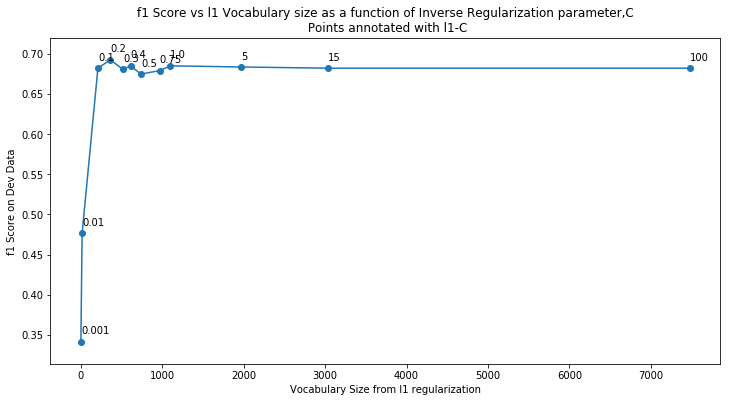

For C=0.3, the l1 Non Zero Weights = 640, but for l2 it is 107516


In [13]:
def P6():
    '''Function to use l1 regularization to '''
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    ### STUDENT START ###
    
    # Vectorize the data using unigrams
    vectorizer = CountVectorizer()
    new_train_data = vectorizer.fit_transform(train_data)
    features = np.array(vectorizer.get_feature_names())
    
    # Set the C values to loop over and the empty lists for results for plotting later
    cs = [0.0001,0.001, 0.01, 0.1, 0.2,0.3,0.4,0.5,0.75, 1.0,5, 15,100]
    f1scores = []
    nonzerowts=[]
    vocab_sizes=[]
    cplot=[]
    
    print(f"Inverse Regularization Strength C versus vocabulary size \n")
    
    # Do the 
    for c in cs:
        # Define the classifier using l1 regularization here
        clf_l1 = LogisticRegression(multi_class='ovr', penalty='l1', solver='liblinear',C=c, tol=0.01, max_iter=500)
        
        # Train the model using L1 regularization
        model = clf_l1.fit(new_train_data,train_labels) # Train
        
        # Get the Model weights and count the number of non-zero weights
        weights_l1 = model.coef_
        tot_nonzero_weights_l1 = np.count_nonzero(weights_l1)
        
        # Create a mask from the non-zero weights and set an empty list for the vocabulary, l1_v
        mask=weights_l1.astype(bool)
        l1_v = []
        
        # for each class, mask the features by the non-zero weights to pull out the relevant features and add to the list
        for row in range(0,mask.shape[0]):
            vector = list(features[mask[row,:]])
            l1_v.extend(vector)
        
        # For each pass, measure the length of the non-zero weights list and set the vocabulary as the unique features
        nonzerowts.append(len(l1_v))
        l1_vocab = list(set(l1_v))
        
        # Only continue if there are words in the vocabulary (for very small C, there will be none)
        if len(l1_vocab)>0:            
            # Specify the vocabulary to be used on this pass as the one pruned by the l1 regularization above
            # and vectorize the train data with the new vocabulary
            vectorizer2 = CountVectorizer(vocabulary= l1_vocab) 
            newer_train_data=vectorizer2.fit_transform(train_data)
            
            # Train a new model using l2 regularization based on l1 vocaabulary, using the C value in the current loop
            clf_l2 = LogisticRegression(multi_class='ovr', penalty='l2', solver='liblinear', C=c, tol=0.01, max_iter=500)
            model2 = clf_l2.fit(newer_train_data,train_labels)

            # Predict labels with the new regularization, use the new vectorizer as well
            newer_dev_data=vectorizer2.transform(dev_data)
            pred_labels = model2.predict(newer_dev_data)
            
            # Calculate the f1 score and data for plotting
            f1score = metrics.f1_score(dev_labels,pred_labels,average='micro')
            f1scores.append(f1score)
            vocab_sizes.append(len(l1_vocab))
            cplot.append(c)
        else:
            print(f'Zero length vocabulary, cannot fit L2 model for C={c}')

    f1scores = list(f1scores)
    vocab_sizes=list(vocab_sizes)
    cplot=list(cplot)
    print(f'f1 score when C=100 is {f1scores[-1]:.4}')
        
    # Create plot
    plt.figure(figsize = (12,6))
    plt.scatter(vocab_sizes,f1scores)
    plt.plot(vocab_sizes,f1scores)
    for i,txt in enumerate(cplot):
        plt.annotate(txt,(vocab_sizes[i]-0.1,f1scores[i]+0.01))
    plt.xlabel('Vocabulary Size from l1 regularization')
    plt.ylabel('f1 Score on Dev Data')
    plt.title('f1 Score vs l1 Vocabulary size as a function of Inverse Regularization parameter,C\n Points annotated with l1-C')
    plt.show()
    
    # Base L2 regularized model for reference to get unmodified number of non-zero weights
    again_train_data = vectorizer.fit_transform(train_data)
    again_clf = LogisticRegression(multi_class='ovr', penalty='l2', solver='liblinear',C=0.3)
    again_model = again_clf.fit(new_train_data,train_labels) # Train
    again_weights = again_model.coef_
    
    print(f'For C=0.3, the l1 Non Zero Weights = {nonzerowts[4]}, but for l2 it is {np.count_nonzero(again_weights)}')

    ### STUDENT END ###
P6()

**Answer**  

The plot above shows that as vocabulary size grows past about 1000, which corresponds to a C value of about 1, there is not a significant increase in the f1 score, and in the end it is approximately the same as previous attempts (~0.71). The advantage of this approach is obtaining reasonably good classficiation with a signficantly smaller vocabulary, which should be more efficient - especially in cases like this where we have a large number of features (25,000 plus) but a relatively small number of examples (2034). For instance, when C=0.3, there are only 640 non-zero weights when pruned by using l1 regularization, whereas a similar exercise with no pruning using l2 regularization has 107,516 non-zero weights - more than 2 orders of magnitude different. This is, in essence, a simple way to do feature selection without causing underfitting, and allowing good generalization of the model.



----

**(7)**  

Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

[4 pts]

In [16]:
def P7():
    ### STUDENT START ###
    vectorizer = TfidfVectorizer()
    new_train_data = vectorizer.fit_transform(train_data)
    
    # Define the classifier
    clf = LogisticRegression(multi_class='ovr', penalty='l2', solver='liblinear',C=100)
    
    # Train the model using L2 regularization
    model = clf.fit(new_train_data,train_labels) # Train
    weights = model.coef_
    
    # Predict
    new_dev_data=vectorizer.transform(dev_data)
    pred_labels = model.predict(new_dev_data)
    f1score = metrics.f1_score(dev_labels,pred_labels,average='micro')
    print(f'f1 score for Tf-idf transformation and Logistic Regression (L2 and C=100) is {f1score:.4}')
    
    # pull probabilities from model and find maximum for each example.
    probabilities = model.predict_proba(new_dev_data)
    num=probabilities.shape[0]
    max_pred_proba = np.amax(probabilities, axis=1).reshape(num,1)
    
    # reshape the dev data labels and pull out the probability that corresponds to the correct label for each example
    dev_lab = dev_labels.reshape(num,1)
    correct_prob = np.take_along_axis(probabilities,dev_lab,axis=1)
    
    # Calculate R: R > 1 indicates incorrect classification
    R = max_pred_proba / correct_prob
    R2 = R.reshape(num,)
    
    # find indices of largest 3 values in the R matrix (used R2 to reshape it for argpartition)
    ind_largest = np.argpartition(-R2,2)
    ind_largest = ind_largest[0:3]
    print('indices of 3 largest errors:', ind_largest)
    
    # Pull out 3 largest values of R
    largest_R = np.take(R,ind_largest)
    np.set_printoptions(precision=4,suppress=True)
    print(f'R values for 3 largest errors: {largest_R}')

    # Print the 3 messages that correspond to the largest R values
    for n in range(0,3):
        pred_lab = pred_labels[ind_largest[n]]
        correct_lab = dev_labels[ind_largest[n]]
        print(f'\n\u001b[1mMisclassified Message with index {ind_largest[n]}\u001b[0m'
             f'\npredicted label {pred_lab}, {newsgroups_train.target_names[pred_lab]}'
             f'\ncorrect label {correct_lab}, {newsgroups_train.target_names[correct_lab]}\n')
        print(dev_data[ind_largest[n]])
    
    ### STUDENT END ###
P7()

f1 score for Tf-idf transformation and Logistic Regression (L2 and C=100) is 0.7633
indices of 3 largest errors: [215 665 607]
R values for 3 largest errors: [929.3576 325.004  287.1791]

Misclassified Message with index 215
predicted label 1, comp.graphics
correct label 3, talk.religion.misc

I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies f

**ANSWER:**  
The Tfidf Vectorizer, which stands for term-frequency times inverse document frequency, works on a frequency basis, similar to the Count Vectorizer. However, where CountVectorizer simply counts the occurence of each specific word (feature) after tokenization, Tf-idf then transforms the counts by 'reducing importance' of the words that occur frequently in all document. Tf-idf takes the number of times a word occurs in a document multiplied by the inverse document frequency (see [https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction] Section 5.2.3.4 for details on the idf), then normalizes the resultant vector by the Euclidean norm (in order to compare vectors such that a very long document doesn't contribute more than a very short one).

After using Tf-idf I note that the classification errors seem to happen when:
- messages have information that correponds to more than one class
- messages are too short
- messages have 'footers' or 'signatures' with separator lines or quotations in them
- there are lots of blank lines in a message
- there are ellipses in the message (...)
- there are underscores in the message  

One of the downsides to the Tf-idf in this case is that for example, a message in the comp.graphics forum might have the word computer in almost every message and thus the frequency/importance of that word would be reduced, thus allowing messages that are related to that topic, but where computer is the only identifiable vocabulary word in the message, to be mis-classified. This is especially relevant for very short messages.

A general issue with this classification (either using simple Counts or Tf-idf) is that a message like the first one above, which should be in the religion class, contains computer specific information and thus shows up in the comp.graphics class.

A few things that should be done to avoid these issues:  
- develop a 'must have' vocabulary that always gets checked - for instance, 'Mormon' for the religion forum and 'computer' for the comp.graphics forum. Add this 'must have' vocabulary to that developed by the Tf-idf transformation. This might be a vocabulary that is established using L1 to do feature selection.
- eliminate blank lines, footers, ellipses and underscores with appropriate pre-processing (not specific to Tf-idf)
- the messages with indices 215 and 665 above both have elements of computer language and religion  - so deciding which category could be very difficult - a custom addition to the vocabulary might help, or L1 regularization to do feature selection.

There will always be a few messages that are completely indistinguishable, containing language that is not specifically part of any category, like 'Thanks for the information' - could belong anywhere, and these messages may never be categorized correctly. (of course, retaining header information in a case like this would be especially useful, and could help solve the issue).

---

**(8) EXTRA CREDIT**

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

- [1 pt] for a reasonable attempt
- [2 pts] for improved performance

In [33]:
def P8():
    ''' Combine Tf-idf with l1 regularization to prune vocabulary before fitting and predicting with l2'''
    np.random.seed(0)

    # Using Tfidf to vectorize
    vectorizer = TfidfVectorizer(stop_words='english',min_df=2,max_df=0.15)
    new_train_data = vectorizer.fit_transform(train_data)

    features = np.array(vectorizer.get_feature_names())

    # Define the classifier using l1 regularization here to do feature selection, using C=20 as a reasonable value
    clf_l1 = LogisticRegression(multi_class='ovr', penalty='l1', solver='liblinear',C=20)

    # Train the model using L1 regularization
    model_l1 = clf_l1.fit(new_train_data,train_labels) # Train

    # Get the Model weights
    weights_l1 = model_l1.coef_

    # Create a mask from the non-zero weights and set an empty list for the vocabulary, l1_v
    mask=weights_l1.astype(bool)
    l1_v = []

    # for each class, mask the features by the non-zero weights to pull out the relevant features and add to the list
    for row in range(0,mask.shape[0]):
        vector = list(features[mask[row,:]])
        l1_v.extend(vector)

    # Set the vocabulary as the unique features
    l1_vocab = list(set(l1_v))

    # Specify the vocabulary as the one pruned by the l1 regularization above
    # and vectorize the train data with the new vocabulary
    vectorizer2 = CountVectorizer(vocabulary= l1_vocab, min_df=2, max_df=0.15)
    newer_train_data=vectorizer2.fit_transform(train_data)

    # Train a new model using l2 regularization based on l1 vocaabulary, using the C value as above
    clf_l2 = LogisticRegression(multi_class='ovr', penalty='l2', solver='liblinear', C=20)
    model_l2 = clf_l2.fit(newer_train_data,train_labels)

    # Predict labels with the new regularization, use the new vectorizer as well
    newer_dev_data=vectorizer2.transform(dev_data)
    pred_labels = model_l2.predict(newer_dev_data)

    # Calculate the f1 score and print
    f1score = metrics.f1_score(dev_labels,pred_labels,average='micro')

    print(f'f1 score for dev data using l1 to prune vocabulary using Tf-idf transformation and l2 for classification = {f1score:.4}')
P8()

f1 score for dev data using l1 to prune vocabulary using Tf-idf transformation and l2 for classification = 0.6938


**Answer**  

This solution did not improve over the strict L2 classification from problem 7, in fact it is not as good. More work to be done!